In [15]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

* hyperopt implements distributed asynchronous algorithm for hyperparameter optimization.

In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
fspace = {
    'x': hp.uniform('x', -5, 5)
}
def f(params):
    x = params['x']
    val = x**2
    return {'loss': val, 'status': STATUS_OK}
trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=50, trials=trials)
print('best:', best)
print('trials:')
for trial in trials.trials[:2]:
    print(trial)
    print('\n')

100%|██████████| 50/50 [00:00<00:00, 166.55trial/s, best loss: 0.01507364348667296]
best: {'x': 0.12277476730449527}
trials:
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 0.9553151764499711, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [0]}, 'vals': {'x': [-0.9774022592822114]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 7, 13, 15, 18, 5, 921000), 'refresh_time': datetime.datetime(2020, 7, 13, 15, 18, 5, 921000)}


{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 20.249877028898897, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'x': [1]}, 'vals': {'x': [-4.499986336523579]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 7, 13, 15, 18, 5, 923000), 'refresh_time': datetime.datetime(2020, 7, 13, 15, 18, 5, 923000)}




## Implementing on IRIS dataset

In [17]:
from sklearn.datasets import load_iris
data = load_iris()

In [18]:
#print('Feature Names:', data.feature_names)
#print('Target Names:', data.target_names)
#print('Description Names:', data.DESCR)

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
  species   measurement  value
0  setosa  sepal_length    5.1
1  setosa  sepal_length    4.9
2  setosa  sepal_length    4.7
3  setosa  sepal_length    4.6
4  setosa  sepal_length    5.0


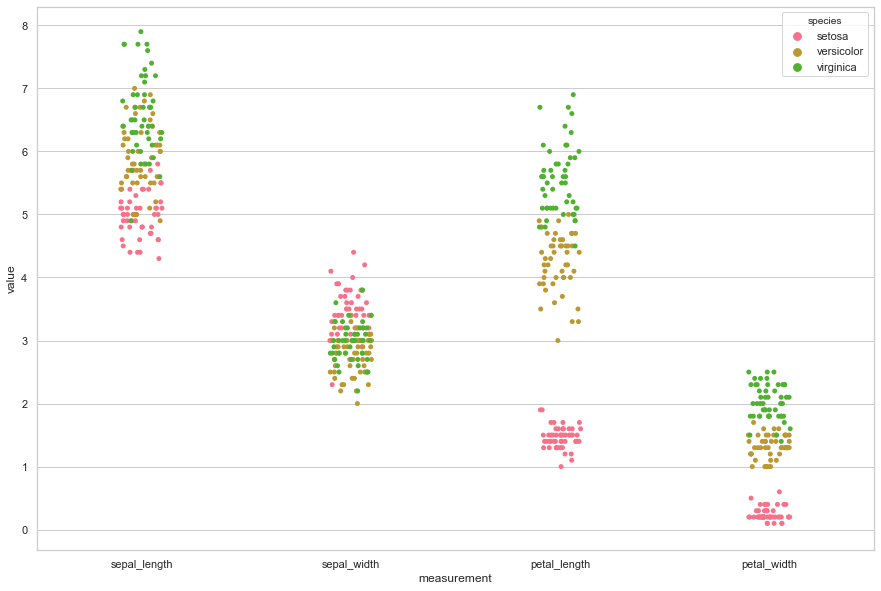

In [19]:
import seaborn as sns
sns.set(style="whitegrid", palette="husl")
iris = sns.load_dataset("iris")
print(iris.head())
iris = pd.melt(iris, "species", var_name="measurement")
print(iris.head())
f, ax = plt.subplots(1, figsize=(15,10))
sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax)

## K-Nearest Neighbors


In [20]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [21]:
X = data.data
y = data.target

In [22]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()


In [23]:
space4knn = {
    'n_neighbors':hp.choice('n_neighbors', range(1, 100))
}

In [24]:
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status':STATUS_OK }

    

In [25]:
trial = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100)
print('best:')
print(best)

100%|██████████| 100/100 [00:04<00:00, 24.16trial/s, best loss: -0.9800000000000001]
best:
{'n_neighbors': 5}


In [26]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC



In [33]:
digits = load_digits()
X = digits.data
y = digits.target
print(X.shape, y.shape)
def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'naive_bayes':
        clf = BernoulliNB(**params)
    elif t == 'svm':
        clf = SVC(**params)
    elif t == 'dtree':
        clf = DecisionTreeClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, X, y).mean()
space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },
    {
        'type': 'randomforest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,5)),
        'n_estimators': hp.choice('n_estimators', range(1,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'scale': hp.choice('scale', [0, 1]),
        'normalize': hp.choice('normalize', [0, 1])
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])
count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        #print('new best:', acc, 'using', params['type'])
        best = acc
    if count % 50 == 0:
        pass
        #print('iters:', count, ', acc:', acc, 'using', params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1500, trials=trials)
print('best:')
print(best)

(1797, 64) (1797,)
100%|██████████| 1500/1500 [12:04<00:00,  2.07trial/s, best loss: -0.9671711544413494]
best:
{'classifier_type': 3, 'knn_n_neighbors': 1}


* Best of the algorithms performing are printed above.
* As per the business need we can use those algorithm.
* [Referred Site](https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt)


### How to define Hyperopt parameters?
#### A parameter is defined with a certain uniformrange or else a probability distribution, such as:
* hp.randint(label, upper)
* hp.uniform(label, low, high)
* hp.loguniform(label, low, high)
* hp.normal(label, mu, sigma)
* hp.lognormal(label, mu, sigma)
#### There is also a few quantized versions of those functions, which rounds the generated values at each step of “q”:
* hp.quniform(label, low, high, q)
* hp.qloguniform(label, low, high, q)
* hp.qnormal(label, mu, sigma, q)
* hp.qlognormal(label, mu, sigma, q)
#### It is also possible to use a “choice” which can lead to hyperparameter nesting:
* hp.choice(label, ["list", "of", "potential", "choices"])
* hp.choice(label, [hp.uniform(sub_label_1, low, high), hp.normal(sub_label_2, mu, sigma), None, 0, 1, "anything"])

### General steps in hyper-parameter
* Step 1: define an objective function
* Step 2: define a configuration space
* Step 3: choose a search algorithm


## HyperOpts Job 
* Hyperopt's job is to find the best value of a scalar-valued, possibly-stochastic function over a set of possible arguments to that function. Whereas many optimization packages will assume that these inputs are drawn from a vector space, Hyperopt is different in that it encourages you to describe your search space in more detail. By providing more information about where your function is defined, and where you think the best values are, you allow algorithms in hyperopt to search more efficiently.

## The way to use hyperopt is to describe:

* the objective function to minimize
* the space over which to search
* the database in which to store all the point evaluations of the search
* the search algorithm to use

### Bayesian Optimization Primer
* Optimization is finding the input value or set of values to an objective function that yields the lowest output value, called a “loss”. The objective function f(x) = x² has a single input and is a 1-D optimization problem. Typically, in machine learning, our objective function is many-dimensional because it takes in a set of model hyperparameters. For simple functions in low dimensions, we can find the minimum loss by trying many input values and seeing which one yields the lowest loss. We could create a grid of input values and try all of them — grid search — or randomly pick some values — random search. As long as evaluations of the objective function (“evals”) are cheap, these uninformed methods might be adequate. However, for complex objective functions like the 5-fold cross validation error of a neural network, each eval of the objective function means training the network 5 times!

* For models that take days to train, we want a way to limit calls to the evaluation function. Random search is actually more efficient than grid search for problems with high dimensions, but is still an uniformed method where the search does not use previous results to pick the next input values to try. Let’s see if you’re smarter than random search. Say we have the following results from training a random forest for a regression task:
* Bayesian optimization, also called Sequential Model-Based Optimization (SMBO), implements this idea by building a probability model of the objective function that maps input values to a probability of a loss: p (loss | input values). The probability model, also called the surrogate or response surface, is easier to optimize than the actual objective function. Bayesian methods select the next values to evaluate by applying a criteria (usually Expected Improvement) to the surrogate. The concept is to limit evals of the objective function by spending more time choosing the next values to try.
* Bayesian Reasoning means updating a model based on new evidence, and, with each eval, the surrogate is re-calculated to incorporate the latest information. The longer the algorithm runs, the closer the surrogate function comes to resembling the actual objective function. Bayesian Optimization methods differ in how they construct the surrogate function: common choices include Gaussian Processes, Random Forest Regression, and, the choice in Hyperopt, the Tree Parzen Estimator (TPE).

[lightgbm, xgboost hyperopt kaggle kernel](https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt)